# **Classification of Shapes**

## **Importing modules**

In [12]:
import os
import pathlib
import cv2
import glob
from PIL import Image
import pandas as pd
import numpy as np
from prettytable import PrettyTable
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.utils import to_categorical
import random
import matplotlib.pyplot as plt
%matplotlib inline


## **Loading the data and Preprocessing**

In [2]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_images_from_folder(folder):
    num_of_images = 0
    for filename in glob.glob(folder):
        #print(filename)
        idx= filename.find("synth_")
        part_type = filename[idx+6:idx+9]
        length = float(filename[idx+11:idx+14])
        width = float(filename[idx+16:idx+19])
        height= float(filename[idx+21:idx+24])
        partx = float(filename[idx+26:idx+31])
        party = float(filename[idx+33:idx+38])
        partz = float(filename[idx+40:idx+45])
        ang1  = float(filename[idx+47:idx+50])
        ang2  = float(filename[idx+52:idx+55])
        ang3  = float(filename[idx+57:idx+60])
        cam1= float(filename[idx+64:idx+68])
        cam2= float(filename[idx+72:idx+76])
        cam3= float(filename[idx+80:idx+84])
        cam4= float(filename[idx+88:idx+92])

        if part_type=="cyl":
            volume = 3.1415 * length * (width/2.0)**2
            y_one_hot = np.array([[1, 0, 0]])
        if part_type=="cub":
            volume = length * width * height
            y_one_hot = np.array([[0, 1, 0]])
        if part_type == "sph":
            volume = (4.0/3.0) * 3.1415 * (length / 2.0)**3
            y_one_hot = np.array([[0, 0, 1]])

        # print(part_type)
        # print(length, width, height, volume)
        # print(partx, party, partz)
        # print(ang1, ang2, ang3)
        # print(cam1, cam2, cam3, cam4)

#       print(filename)
        image = cv2.imread(filename)
#       cv2.imshow('Original image', image)
#       print(image[10,10])
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#       print(gray[10,10])
#       cv2.imshow('Gray image', gray)

        if gray is not None:
            num_of_images += 1
            gray_r = gray.reshape(1, gray.shape[0], gray.shape[1], 1)

            if num_of_images == 1:
                sizex = gray.shape[0]
                sizey = gray.shape[1]
                x_image = gray_r.copy()
                x_numeric = np.array([[cam1, cam2, cam3, cam4]])
                y_shape = y_one_hot.copy()
                y_size = np.array([[length, width, height, ang1, ang2, ang3, volume]])
            else:
                if (gray.shape[0] == sizex) and (gray.shape[1] == sizey):
                    x_image = np.append(x_image, gray_r, axis=0)
                    x_numeric = np.append(x_numeric, np.array([[cam1, cam2, cam3, cam4]]), axis=0)
                    y_shape = np.append(y_shape, y_one_hot, axis=0)
                    y_size = np.append(y_size,
                                       np.array([[length, width, height, ang1, ang2, ang3, volume]]), axis=0)
                else:
                    print(sizex, gray.shape[0])
                    print(sizey, gray.shape[1])
                    print('Image number', num_of_images, ' : Size mis-match')
                    exit()
        #print("Shape of x :", x.shape, end='\n         ')
        #print("Shape of y :", y.shape, end='\n         ')
        #print(str(num_of_images)+' '+filename+' '+str(gray.shape))

    print("Data read from ", str(folder), end='\n      ')
    print("Total number of images read =", x_image.shape[0], end='\n      ')
    print("Pixels in each image =", sizex, ' * ', sizey, end='\n      ')
    print("Total number of pixels", sizex * sizey, end='\n         ')

    return x_image, x_numeric, y_shape, y_size, sizex, sizey

In [4]:
def create_data_sets():
    #read synthetic data set
    dirname_regression_data = "/content/drive/MyDrive/college_project/synthetic_shape_data_all-20211208T180010Z-001"
    dirname = os.listdir(dirname_regression_data)

    print("Number of directories :", len(dirname),"\n")

    num_of_dir = 0
    for dir in dirname:
        num_of_dir += 1
        folder_name = str(dirname_regression_data)+str('/')+str(dir)+str('/*.png')

        #print(folder_name)

        (x_image, x_numeric, y_shape, y_size, sizex, sizey) = load_images_from_folder(folder_name)

        x_set = x_image.copy()
        y_set = y_shape.copy()

        if num_of_dir == 1:
            print("Creating first dataset\n")
            x = x_set.copy()
            y = y_set.copy()
        else:
            print("Appending datasets\n")
            x = np.append(x, x_set, axis=0)
            y = np.append(y, y_set, axis=0)

    #rand_pic=np.random.randint(0,m)
    #arr=x[rand_pic,:].reshape(sizex, sizey)
    #im = Image.fromarray(arr)
#    im.show()

    #arr = x[rand_pic, 0:num_pix//2].reshape(sizex//2, sizey)
    #im = Image.fromarray(arr)
#    im.show()

    #arr1 = arr[:,0:sizey//2]
    #im = Image.fromarray(arr1)
#    im.show()

    return x, y, sizex, sizey

In [5]:
x,y,size_x,size_y=create_data_sets()

Number of directories : 65 

Data read from  /content/drive/MyDrive/college_project/synthetic_shape_data_all-20211208T180010Z-001/sph_D035/*.png
      Total number of images read = 100
      Pixels in each image = 142  *  142
      Total number of pixels 20164
         Creating first dataset

Data read from  /content/drive/MyDrive/college_project/synthetic_shape_data_all-20211208T180010Z-001/sph_D045/*.png
      Total number of images read = 100
      Pixels in each image = 142  *  142
      Total number of pixels 20164
         Appending datasets

Data read from  /content/drive/MyDrive/college_project/synthetic_shape_data_all-20211208T180010Z-001/sph_D042/*.png
      Total number of images read = 100
      Pixels in each image = 142  *  142
      Total number of pixels 20164
         Appending datasets

Data read from  /content/drive/MyDrive/college_project/synthetic_shape_data_all-20211208T180010Z-001/sph_D050/*.png
      Total number of images read = 100
      Pixels in each image =

Text(0.5, 0.98, 'Sample Images of different shapes')

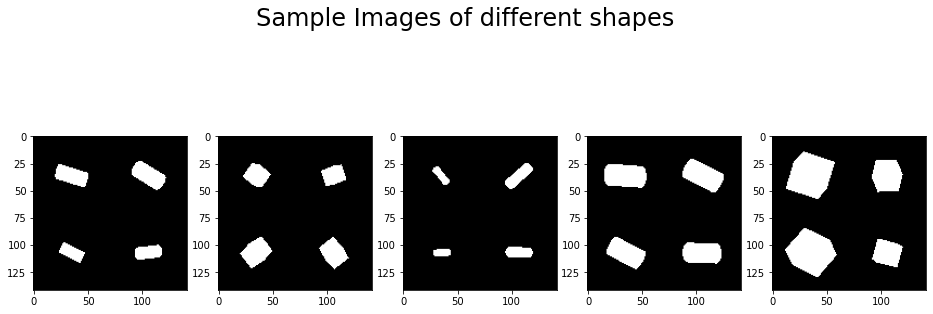

In [6]:
num_images = 6438
fig, ax = plt.subplots(1,5,figsize = (16,6))
for i in range(0,5):
    image_index = random.randint(0,num_images)
    ax[i].imshow(x[image_index].reshape((142,142)),cmap="gray")
fig.suptitle('Sample Images of different shapes', fontsize = 24)

In [7]:
y.shape

(6438, 3)

In [8]:
y[:5]

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [9]:
x.shape

(6438, 142, 142, 1)

## **Splitting into train and test datasets**

In [10]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [13]:
# scale pixels
def prep_pixels(x_train,x_test):
  # convert from integers to floats
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train_norm= x_train/255.0
  x_test_norm=x_test/255.0
	# return normalized images
  return x_train_norm,x_test_norm

In [14]:
x_train_norm,x_test_norm=prep_pixels(x_train,x_test)

## **Creating a model**

In [15]:
def define_model(filter):
  #defining the model based on filters
  model = Sequential()
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003), input_shape=(142, 142, 1)))
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
  model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
  model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
  model.add(Conv2D(filter*4, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
  model.add(Conv2D(filter*4, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(filter*4, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.003)))
  model.add(Dense(3, activation='softmax'))
	# compile model
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())
  return model
 

In [16]:
#16 with 25 epochs
model=define_model(32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 142, 142, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 142, 142, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 71, 71, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 71, 71, 64)        36928     
                                                        

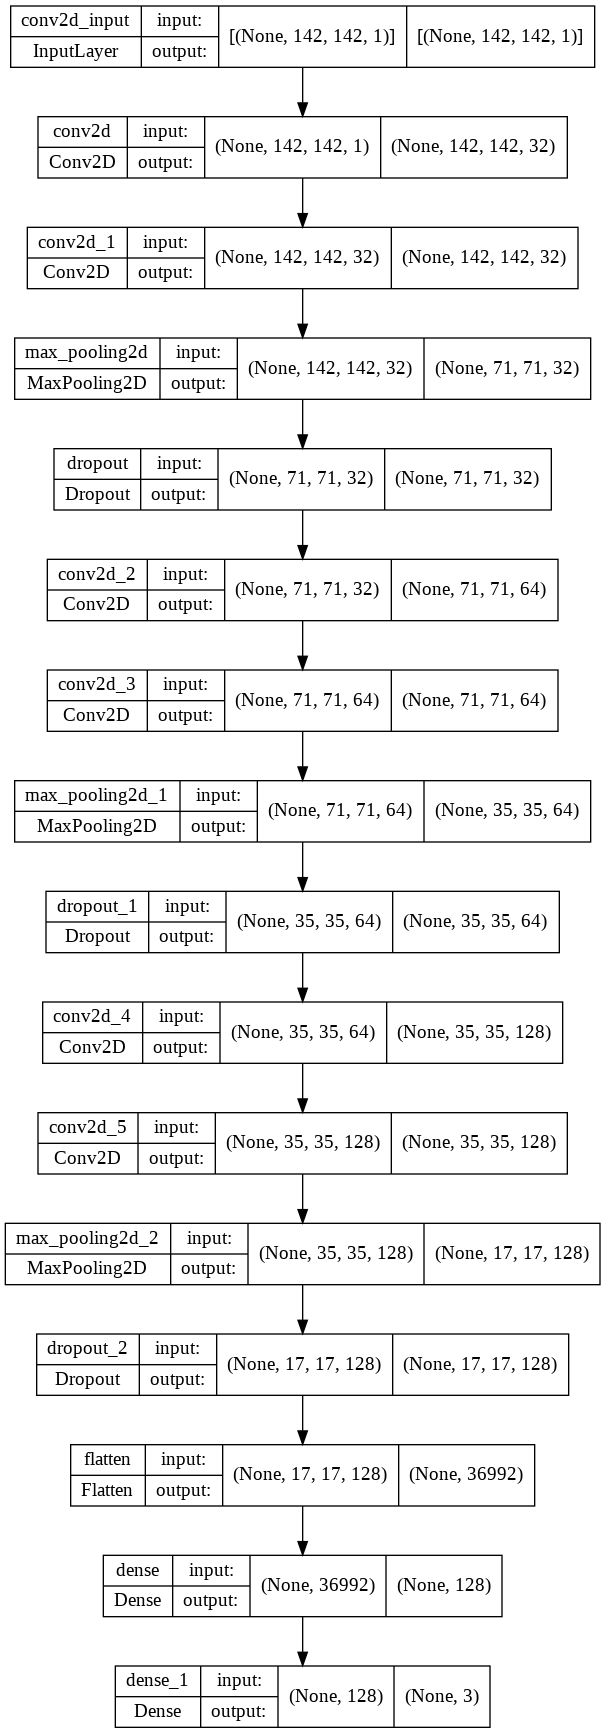

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## **Evaluating the results with test data**

In [ ]:
# fit model
model_history = model.fit(x_train_norm, y_train, epochs=50, batch_size=64, validation_data=(x_test_norm, y_test), verbose=1)

Epoch 1/50
81/81 [==============================] - 34s 249ms/step - loss: 5.3846 - accuracy: 0.4161 - val_loss: 3.9445 - val_accuracy: 0.4356
Epoch 2/50
81/81 [==============================] - 18s 223ms/step - loss: 3.5363 - accuracy: 0.5186 - val_loss: 3.1113 - val_accuracy: 0.6351
Epoch 3/50
81/81 [==============================] - 18s 223ms/step - loss: 2.7881 - accuracy: 0.6610 - val_loss: 2.4157 - val_accuracy: 0.7453
Epoch 4/50
81/81 [==============================] - 18s 223ms/step - loss: 2.2408 - accuracy: 0.7839 - val_loss: 1.9371 - val_accuracy: 0.8641
Epoch 5/50
81/81 [==============================] - 18s 222ms/step - loss: 1.8704 - accuracy: 0.8431 - val_loss: 1.6466 - val_accuracy: 0.8998
Epoch 6/50
81/81 [==============================] - 18s 223ms/step - loss: 1.6104 - accuracy: 0.8711 - val_loss: 1.4701 - val_accuracy: 0.8991
Epoch 7/50
81/81 [==============================] - 18s 223ms/step - loss: 1.4067 - accuracy: 0.8860 - val_loss: 1.3491 - val_accuracy: 0.8649

In [ ]:
# evaluate model
_, acc = model.evaluate(x_test_norm, y_test, verbose=1)
print('The accuracy of test data is %.3f' % (acc * 100.0))

41/41 [==============================] - 3s 40ms/step - loss: 0.3006 - accuracy: 0.9472
The accuracy of test data is 94.720


Text(0.5, 0.98, 'Model Training and Test Loss and Accuracy')

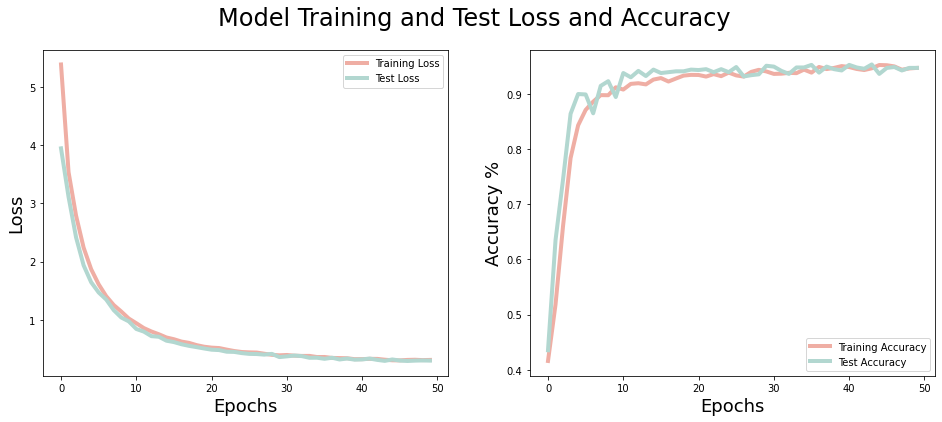

In [ ]:
# learning curves
# plot train and val acc as  a function of epochs
fig, ax = plt.subplots(1,2,figsize = (16,6))
ax[0].plot(model_history.history['loss'],color='#EFAEA4',label = 'Training Loss',linewidth=4.0)
ax[0].plot(model_history.history['val_loss'],color='#B2D7D0',label = 'Test Loss',linewidth=4.0)
ax[1].plot(model_history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy',linewidth=4.0)
ax[1].plot(model_history.history['val_accuracy'],color='#B2D7D0',label = 'Test Accuracy',linewidth=4.0)
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs', fontsize=18)
ax[1].set_xlabel('Epochs', fontsize=18)
ax[0].set_ylabel('Loss', fontsize=18)
ax[1].set_ylabel('Accuracy %', fontsize=18);
fig.suptitle('Model Training and Test Loss and Accuracy', fontsize = 24)

In [ ]:
# your code here
print('CNN Regularized Model Summary')
model_table= PrettyTable()

model_table.field_names = ["Parameter", "Train", "Validation", "Difference (Train-Val)"]
model_table.add_row(["Loss", round(model_history.history['loss'][-10],2), round(model_history.history['val_loss'][-10],6), round(model_history.history['loss'][-10]-model_history.history['val_loss'][-10],6)])
model_table.add_row(["Accuracy", round(model_history.history['accuracy'][-10],6), round(model_history.history['val_accuracy'][-10],6), round(model_history.history['accuracy'][-10]-model_history.history['val_accuracy'][-10],6)])
print(model_table)

CNN Regularized Model Summary
+-----------+----------+------------+------------------------+
| Parameter |  Train   | Validation | Difference (Train-Val) |
+-----------+----------+------------+------------------------+
|    Loss   |   0.33   |  0.320957  |        0.004997        |
|  Accuracy | 0.948738 |  0.95264   |       -0.003902        |
+-----------+----------+------------+------------------------+


## **Error Analysis**

In [ ]:
y_train_df = pd.DataFrame(y_train, columns = ['cylinder', 'cube','sphere'])
y_test_df = pd.DataFrame(y_test, columns = ['cylinder', 'cube','sphere'])

In [ ]:
y_train_df.values.argmax(axis=1)

array([0, 0, 0, ..., 1, 1, 2])

Text(0.5, 1.0, 'Confusion Matrix - Test data')

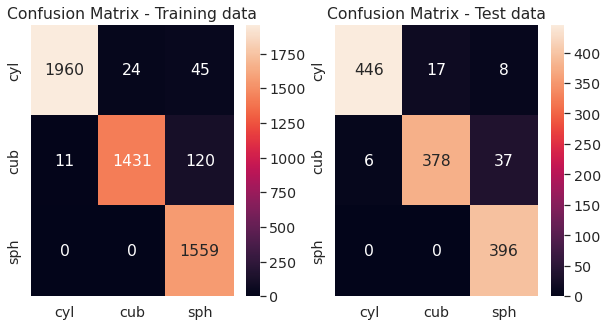

In [ ]:


y_train_pred = np.where(model.predict(x_train_norm)>0.5, 1, 0)
y_test_pred = np.where(model.predict(x_test_norm)>0.5, 1, 0)
y_train_pred_df = pd.DataFrame(y_train_pred, columns = ['cylinder', 'cube','sphere'])
y_test_pred_df = pd.DataFrame(y_test_pred, columns = ['cylinder', 'cube','sphere'])
#y_pred.shape

cm1 = confusion_matrix(y_train_df.values.argmax(axis=1), y_train_pred_df.values.argmax(axis=1))

fig, axes = plt.subplots(1,2,figsize=(10,5))

#df_cm1 = pd.DataFrame(cm1)
df_cm1 = pd.DataFrame(cm1, index = ['cyl','cub','sph'],columns = ['cyl','cub','sph'])
sns.set(font_scale=1.3)
sns.heatmap(df_cm1, annot=True,fmt= 'g', ax = axes[0])
#axes[0].set_ylim([0,2]);
axes[0].set_title('Confusion Matrix - Training data')
cm2 = confusion_matrix(y_test_df.values.argmax(axis=1), y_test_pred_df.values.argmax(axis=1))
#df_cm1 = pd.DataFrame(cm2)
df_cm2 = pd.DataFrame(cm2, index = ['cyl','cub','sph'],columns = ['cyl','cub','sph'])
sns.set(font_scale=1.3)
sns.heatmap(df_cm2, annot=True,fmt= 'g', ax = axes[1])
#axes[1].set_ylim([0,2]);
axes[1].set_title('Confusion Matrix - Test data')

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.metrics import classification_report
model_train_auc = roc_auc_score(y_train_df,y_train_pred_df)
recall = (cm1[1][1])/cm1.sum(axis=1)[1]
fpr = (cm1[0][1])/cm1.sum(axis=1)[0]
precision = (cm1[1][1])/cm1.sum(axis=0)[1]
f1_score = (2*precision*recall)/(recall+precision)
print(classification_report(y_train_df,y_train_pred_df))

print(f'Training ROC-AUC Score : {round(model_train_auc,2)}')

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2029
           1       0.98      0.92      0.95      1562
           2       0.90      1.00      0.95      1559

   micro avg       0.96      0.96      0.96      5150
   macro avg       0.96      0.96      0.96      5150
weighted avg       0.97      0.96      0.96      5150
 samples avg       0.96      0.96      0.96      5150

Training ROC-AUC Score : 0.97


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_test_auc = roc_auc_score(y_test,y_test_pred)
recall = (cm2[1][1])/cm2.sum(axis=1)[1]
fpr = (cm2[0][1])/cm2.sum(axis=1)[0]
precision = (cm2[1][1])/cm2.sum(axis=0)[1]
f1_score = (2*precision*recall)/(recall+precision)
print(classification_report(y_test,y_test_pred))

print(f'Test ROC-AUC Score : {round(model_test_auc,2)}')

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       471
           1       0.96      0.90      0.93       421
           2       0.90      1.00      0.95       396

   micro avg       0.95      0.95      0.95      1288
   macro avg       0.95      0.95      0.95      1288
weighted avg       0.95      0.95      0.95      1288
 samples avg       0.95      0.95      0.95      1288

Test ROC-AUC Score : 0.96


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!pip3 -qq install tf_keras_vis 
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency 
from tf_keras_vis.gradcam import Gradcam
from tensorflow.keras.preprocessing import image
from tf_keras_vis.utils import normalize



Tensorflow recognized 1 GPUs


In [ ]:

shape_dict={0:"cylinder",1:"cube",2:"sphere"}

[1077]


(-0.5, 141.5, 141.5, -0.5)

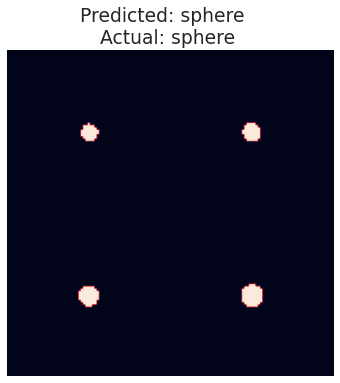

In [ ]:
# Your code here
num_images = 1288
img_list=[]
for i in range(num_images):
    image_index = random.randint(0,num_images)
    pred_class= shape_dict[int(np.squeeze(np.argmax(model.predict(x_test_norm[image_index:image_index+1]),axis=1),axis=0))]
    img = (x_test_norm[image_index])
    true_class = shape_dict[np.argmax(y_test[image_index:image_index+1])]
    if true_class == pred_class:
      img_list.append(image_index)
      print(img_list)
      break
fig = plt.figure(figsize=(6,6))  
plt.imshow(img.reshape(142,142))
fig.suptitle(f'Predicted: {pred_class} \n Actual: {true_class}')
plt.axis('off')

In [ ]:
# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
shape_label = np.argmax(y_test[image_index:image_index+1])
score = CategoricalScore([shape_label])
print(shape_label,score)

2 <tf_keras_vis.utils.scores.CategoricalScore object at 0x7fca89766bd0>


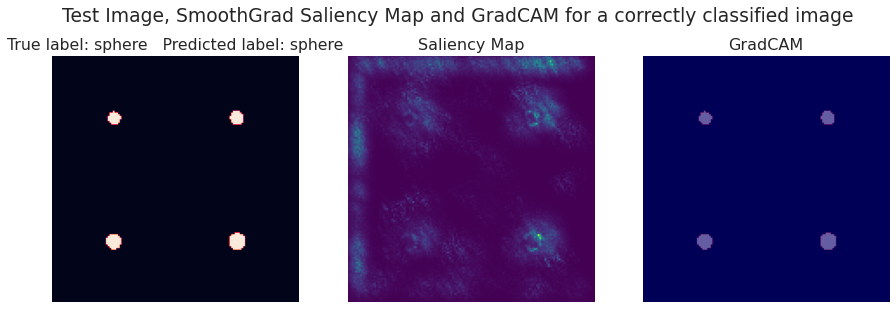

In [ ]:

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
img = image.img_to_array(img)
img = np.float32(img)
saliency_map = saliency(score, img, smooth_samples=20, smooth_noise=0.2)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              img,
              penultimate_layer=-1)
cam = normalize(cam)
# Render
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].imshow(img.reshape(142,142))
ax[0].set_title('True label: '+ true_class + '   Predicted label: ' + pred_class)
ax[0].axis('off')

ax[1].set_title('Saliency Map', fontsize=16)
ax[1].imshow(saliency_map[0], cmap='viridis')
ax[1].axis('off')

ax[2].imshow(img.reshape(142,142))
ax[2].set_title('GradCAM', fontsize=16)
ax[2].imshow(cam[0], cmap='jet', alpha=0.6)
ax[2].axis('off')

fig.suptitle('Test Image, SmoothGrad Saliency Map and GradCAM for a correctly classified image')
#plt.tight_layout()
plt.show()

[302]


(-0.5, 141.5, 141.5, -0.5)

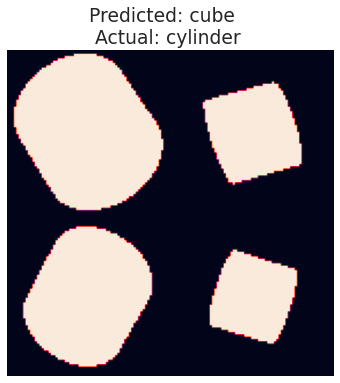

In [ ]:
# Your code here
num_images = 1288
img_list=[]
for i in range(num_images):
    image_index = random.randint(300,303)
    pred_class= shape_dict[int(np.squeeze(np.argmax(model.predict(x_test_norm[image_index:image_index+1]),axis=1),axis=0))]
    img = (x_test_norm[image_index])
    true_class = shape_dict[np.argmax(y_test[image_index:image_index+1])]
    if true_class != pred_class:
      img_list.append(image_index)
      print(img_list)
      break
fig = plt.figure(figsize=(6,6))  
plt.imshow(img.reshape(142,142))
fig.suptitle(f'Predicted: {pred_class} \n Actual: {true_class}')
plt.axis('off')

In [ ]:
# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
shape_label = np.argmax(y_test[image_index:image_index+1])
score = CategoricalScore([shape_label])
print(shape_label)

0


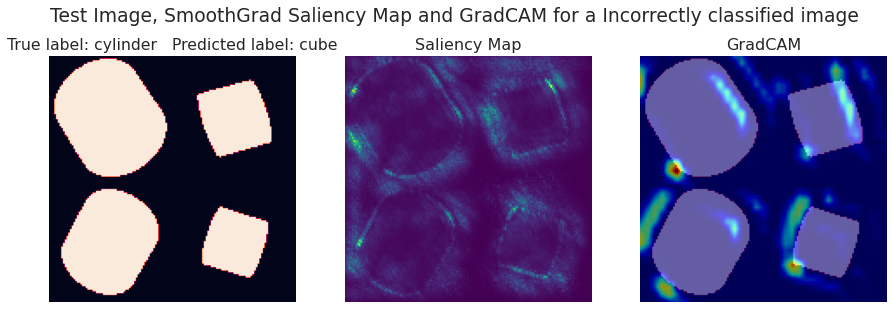

In [ ]:

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
img = image.img_to_array(img)
img = np.float32(img)
saliency_map = saliency(score, img, smooth_samples=20, smooth_noise=0.2)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              img,
              penultimate_layer=-1)
cam = normalize(cam)
# Render
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].imshow(img.reshape(142,142))
ax[0].set_title('True label: '+ true_class + '   Predicted label: ' + pred_class)
ax[0].axis('off')

ax[1].set_title('Saliency Map', fontsize=16)
ax[1].imshow(saliency_map[0], cmap='viridis')
ax[1].axis('off')

ax[2].imshow(img.reshape(142,142))
ax[2].set_title('GradCAM', fontsize=16)
ax[2].imshow(cam[0], cmap='jet', alpha=0.6)
ax[2].axis('off')

fig.suptitle('Test Image, SmoothGrad Saliency Map and GradCAM for a Incorrectly classified image')
#plt.tight_layout()
plt.show()

In [ ]:
# Your code here
#consider all the images
num_images = 1288
img_list=[]
for i in range(num_images):
    #image_index = random.randint(0,num_images)
    pred_class= shape_dict[int(np.squeeze(np.argmax(model.predict(x_test[i:i+1]),axis=1),axis=0))]
    img = x_test[i]
    true_class = shape_dict[np.argmax(y_test[i:i+1])]
    if true_class != pred_class:
      img_list.append(i)
print("The number of incorrectly predicted images are: "+ str(len(img_list)))

The number of incorrectly predicted images are: 81


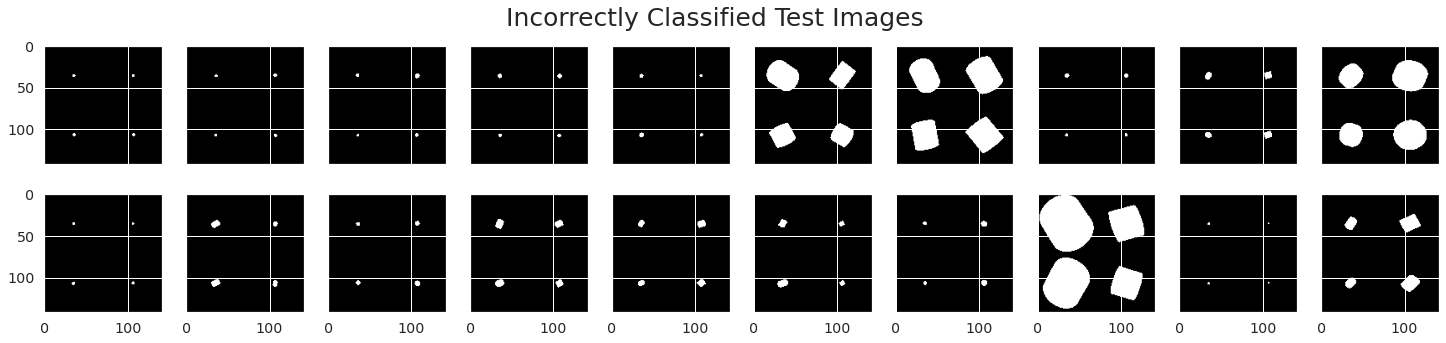

In [ ]:
fig,ax = plt.subplots(2,10, figsize=(25,5), sharex=True, sharey=True)
for i in range(20):
    image=np.squeeze(x_test_norm[img_list[i]].reshape(142,142))
    ax[i%2][i//2].imshow(image,cmap='gray')
fig.suptitle('Incorrectly Classified Test Images ', fontsize=25)
#fig.tight_layout()
fig.show()

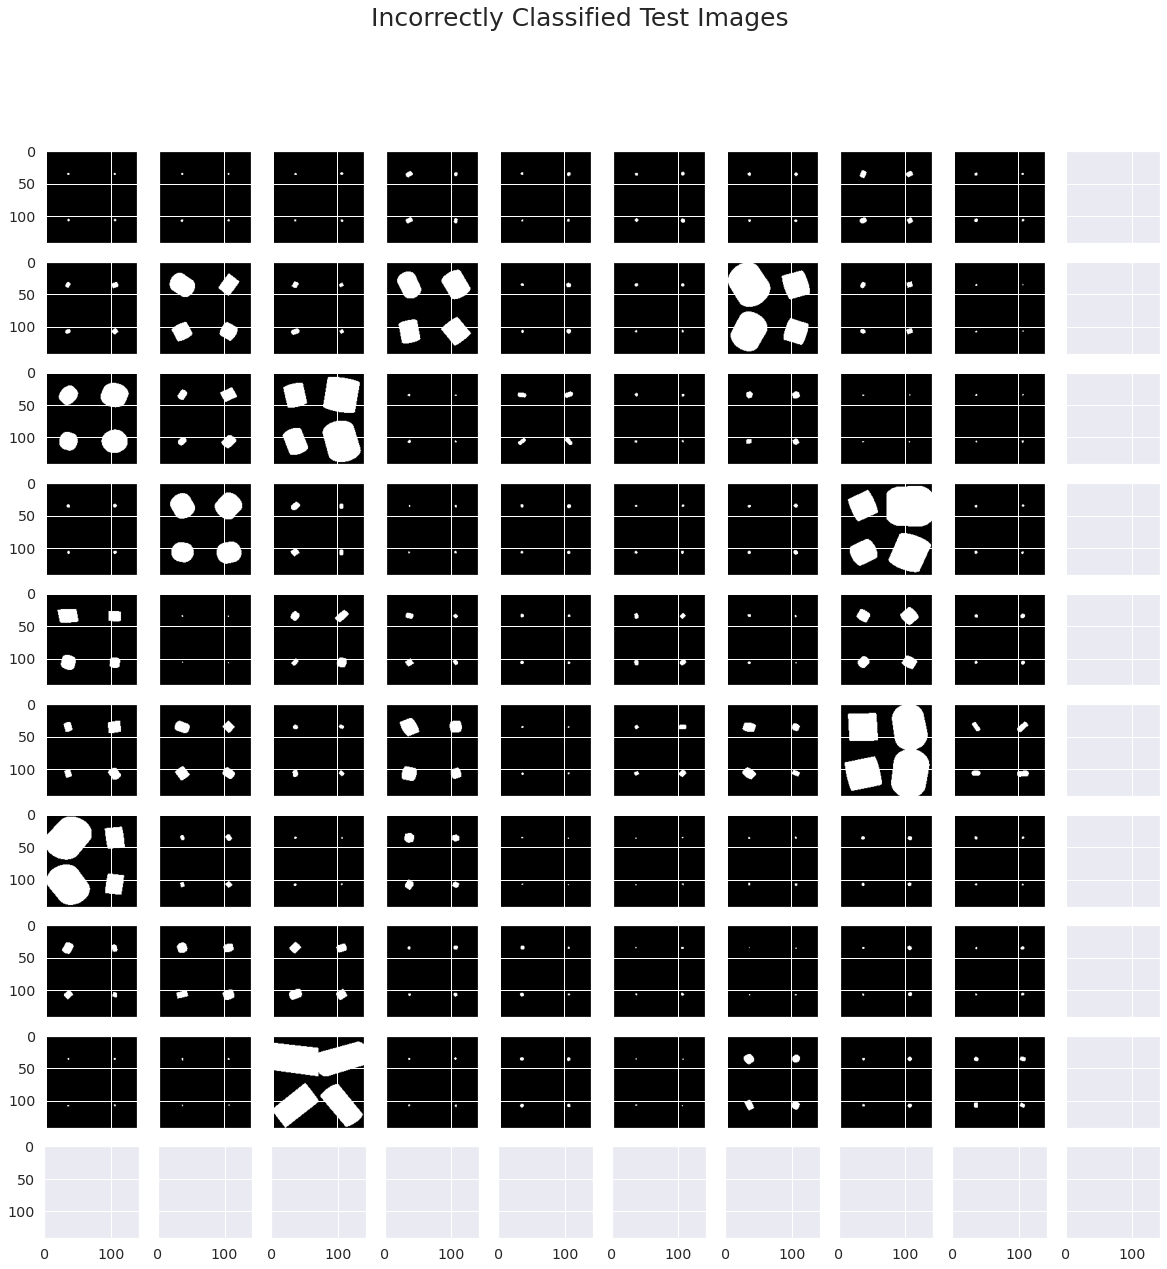

In [ ]:
fig,ax = plt.subplots(10,10,figsize=(20,20), sharex=True, sharey=True)
count=0
for i in range(0,9):
  for j in range(0,9):
    image=np.squeeze(x_test_norm[img_list[count]].reshape(142,142))
    count+=1
    ax[i][j].imshow(image,cmap='gray')
fig.suptitle('Incorrectly Classified Test Images ', fontsize=25)
#fig.tight_layout()
fig.show()

In [ ]:
img_list[15]

302

### Insights from Error Analysis:
All the images that are small in size are getting predicted as spheres so there are no errors for spheres data in confusion matrix. So, the smaller images that are not spheres are being wrong predicted as its hard for the model is analyse such minor details. On the other hand, images which have bigger shapes are also getting wrongly predicted sometimes. Additionally, cylinder that look like spheres are also wrongly predicted. To make this better, data augmentation with zoom-in can help smaller images and zoom out can help with the bigger images. This enhances the accuracy!